In [29]:
from pathlib import Path
import shutil, os, subprocess
import json, random, cv2
from PIL import Image
from torchvision import transforms
from skimage.restoration import denoise_nl_means, estimate_sigma
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import random
from IPython.display import display
from pathlib import Path
import tempfile, pickle
import numpy as np
import torchvision.transforms as T
from sklearn.linear_model import LogisticRegression
import hdbscan
from PIL import Image
from sklearn.manifold import TSNE
import itertools
from sklearn.metrics import (silhouette_score,calinski_harabasz_score,davies_bouldin_score)
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = Path("/content/drive/MyDrive/281_final_project/plane_classification_data")

In [4]:
categories = ["pituitary", "notumor", "glioma", "meningioma"]

image_paths = sorted(
    str(p)
    for split in ("Training", "Testing")
    for cat   in categories
    for p in (root_dir / split / cat).rglob("*")
)

print("Total images =", len(image_paths))

Total images = 7033


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Use 3-channel since DINOv2 expects RGB
                         std=[0.229, 0.224, 0.225])
])

def load_and_preprocess(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base").to(device).eval()

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB"))
])

In [8]:
class MRIDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img = preprocess(img)
        return img, self.image_paths[idx]

In [11]:
def pil_collate(batch):
    """
    batch = [(img0, path0), (img1, path1), ...]
    returns  imgs: List[PIL.Image], paths: List[str]
    """
    imgs, paths = zip(*batch)
    return list(imgs), list(paths)

dataset = MRIDataset(image_paths)

# DataLoader with the collate
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    collate_fn=pil_collate
)

In [12]:
features, paths = [], []

with torch.no_grad():
    for imgs, path_batch in tqdm(dataloader):
        inputs = processor(images=imgs, return_tensors="pt").to(device)
        outputs = model(**inputs).last_hidden_state[:,0]
        #outputs = model(**inputs).last_hidden_state.mean(dim=1)
        features.append(outputs.cpu())
        paths.extend(path_batch)

features = torch.cat(features).numpy()           # shape: (N, 768)
print("Embeddings extracted:", features.shape)

100%|██████████| 110/110 [16:35<00:00,  9.05s/it]

Embeddings extracted: (7033, 768)


In [31]:
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)
pca_scaled = PCA(n_components=100)
X_scale_pca = pca_scaled.fit_transform(X_scaled)

In [13]:
# pca = PCA(n_components=100)
# X_pca = pca.fit_transform(features)

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scale_pca)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


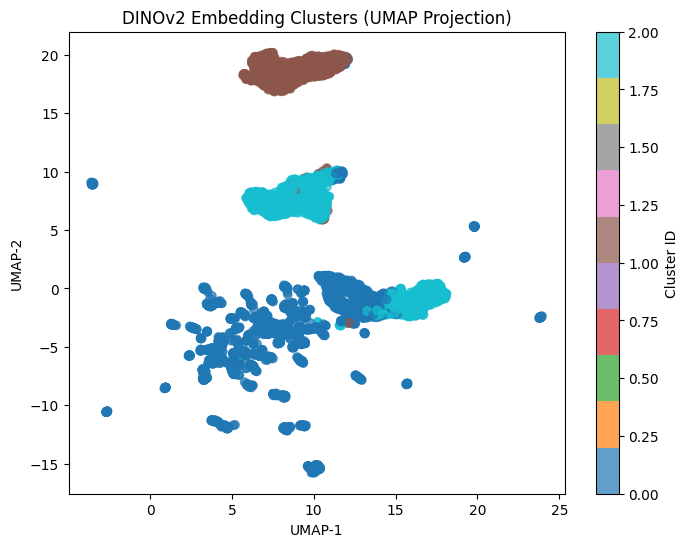

In [33]:
X_umap = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(X_scale_pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("DINOv2 Embedding Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

In [34]:
def show_cluster2(cluster_id, num_samples=10):
    idxs = np.where(cluster_labels == cluster_id)[0][:num_samples]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = Image.open(image_paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')
    plt.show()

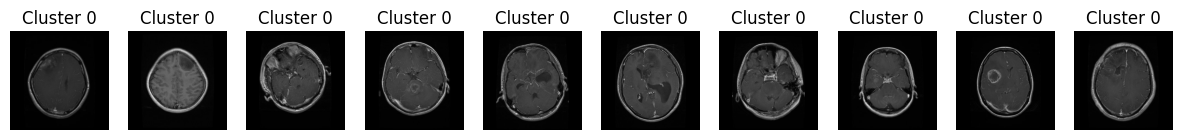

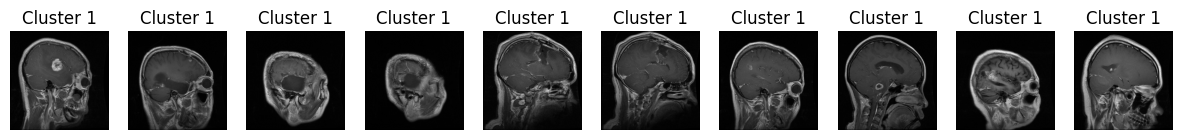

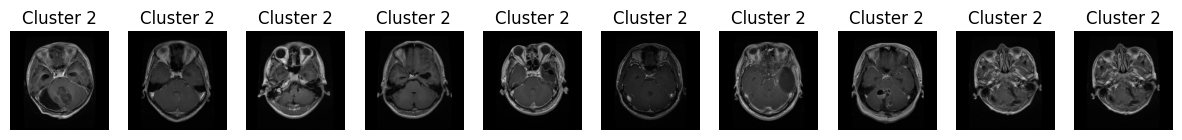

In [35]:
for c in range(3):
    show_cluster2(c)

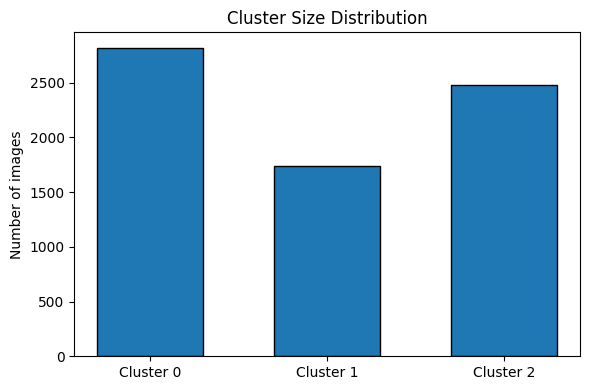

In [36]:
unique, counts = np.unique(cluster_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, width=0.6, edgecolor='k')
plt.xticks(unique, [f"Cluster {i}" for i in unique])
plt.ylabel("Number of images")
plt.title("Cluster Size Distribution")
plt.tight_layout()
plt.show()

In [37]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_scale_pca)

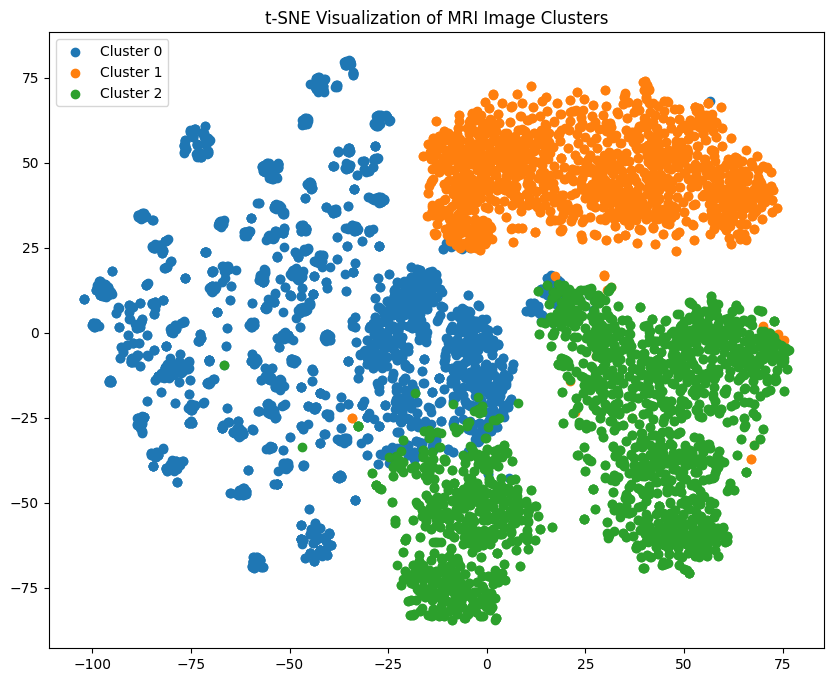

In [38]:
plt.figure(figsize=(10, 8))
for i in range(3):
    idx = cluster_labels == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("t-SNE Visualization of MRI Image Clusters")
plt.show()

In [41]:
sil_score = silhouette_score(X_scale_pca, cluster_labels)
ch_score  = calinski_harabasz_score(X_scale_pca, cluster_labels)
db_score  = davies_bouldin_score(X_scale_pca, cluster_labels)

print(f"Silhouette Score:            {sil_score:.3f}")
print(f"Calinski–Harabasz Index:     {ch_score:.1f}")
print(f"Davies–Bouldin Index:        {db_score:.3f}")

Silhouette Score:            0.139
Calinski–Harabasz Index:     1084.9
Davies–Bouldin Index:        2.223
